# MemorySaver 체크포인트
- 이전 대화기록 기억하고 멀티턴 대화 가능

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

### 그래프 구성

In [15]:
# 도구 정의

from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)

tavily_tool.invoke('랭그래프에서 노드는 무엇인가요?')

{'query': '랭그래프에서 노드는 무엇인가요?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.naver.com/pjt3591oo/223861729229?viewType=pc',
   'title': 'langgraph 소개 및 기본개념 : 네이버 블로그',
   'content': '· 노드(nodes): 그래프의 작업 단위\u200b 노드는 그래프에서 실제 작업을 수행하는 단위입니다. 각 노드는 특정 로직을 담당합니다. 작업은 LLM 호출, 데이터',
   'score': 0.99719906,
   'raw_content': None},
  {'url': 'https://tilnote.io/books/68156a4ebaa37b745385c23b/68156a79baa37b745385c298',
   'title': '3장: LangGraph의 핵심 구성요소 – 노드, 엣지, 상태 관리',
   'content': "노드는 LangGraph 워크플로우에서 하나하나의 작업 구간을 가리킨다. 말하자면 정보 추출, 외부 도구 호출, LLM 응답 생성 등 실제로 '일'이 이루어지는 지점으로, 파이썬",
   'score': 0.99242276,
   'raw_content': None}],
 'response_time': 0.0,
 'request_id': '8ba853b9-5afc-495c-ac77-1a3a081e3101'}

In [16]:
# llm 및 tools

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
print(type(llm))

tools = [tavily_tool]
llm_with_tools = llm.bind_tools(tools)
print(type(llm_with_tools))

<class 'langchain_openai.chat_models.base.ChatOpenAI'>
<class 'langchain_core.runnables.base.RunnableBinding'>


### 

In [17]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[List, add_messages]

In [18]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

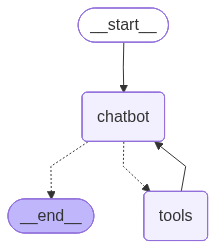

In [20]:
# 노드/엣지 정의, 컴파일

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition



workflow = StateGraph(State)
tool_node = ToolNode(tools)

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'chatbot')
workflow.add_edge('tools', 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition, {'tools': 'tools', END: END})

# 컴파일 시 메모리 세이버 등록하면 설정 끝
graph = workflow.compile(checkpointer=memory)
graph

### 그래프 실행 thread configuration
- 사용자별 thread_id로 사용자별 대화내용 기억

In [21]:
# user1 1st 대화

from langchain_core.messages import HumanMessage

user1_config = {'configurable': {'thread_id': 'user1'}}
user_input = '반갑다, 챗봇! 나는 쪼꼬딸기냠냠이야.'
user1_state = {'messages': [HumanMessage(content=user_input)]}
user1_state = graph.invoke(user1_state, user1_config)
user1_state['messages'][-1].content

'안녕하세요, 쪼꼬딸기냠냠님! 만나서 반가워요. 오늘 뭐 도와드릴까요? 😊'

In [22]:
# user1 2nd 대화

user_input = '내 이름이 뭐라고?'
user1_state = {'messages': [HumanMessage(content=user_input)]}
user1_state = graph.invoke(user1_state, user1_config)
user1_state['messages'][-1].content

'당신의 이름은 쪼꼬딸기냠냠입니다. 맞나요?'

In [23]:
# user2 1st 대화

user2_config = {'configurable': {'thread_id': 'user2'}}
user_input = '안녕 내 이름을 알고 있어?'
user2_state = {'messages': [HumanMessage(content=user_input)]}
user2_state = graph.invoke(user2_state, user2_config)
user2_state['messages'][-1].content

'안녕하세요! 죄송하지만, 저는 당신의 이름을 알 수 없습니다. 어떻게 도와드릴까요?'

In [24]:
# user1 3rd 대화

user_input = '주말에 날씨가 좋은데 나랑 놀러가자. 근데 내 이름이 뭐더라?'
user1_state = {'messages': [HumanMessage(content=user_input)]}
user1_state = graph.invoke(user1_state, user1_config)
user1_state['messages'][-1].content

'쪼꼬딸기냠냠님이라고 부르셨습니다! 주말에 날씨가 좋다니 다행이네요. 어디로 놀러가실 계획이신가요? 😊🌞'

In [25]:
user1_state

{'messages': [HumanMessage(content='반갑다, 챗봇! 나는 쪼꼬딸기냠냠이야.', additional_kwargs={}, response_metadata={}, id='3db5e234-1c53-4f33-916e-b83d6c4c2ce4'),
  AIMessage(content='안녕하세요, 쪼꼬딸기냠냠님! 만나서 반가워요. 오늘 뭐 도와드릴까요? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 1293, 'total_tokens': 1327, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-CdQVf2XOL37NOza0HmaJWXQA7nCSz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--28af6fe8-1ff3-4a45-844b-88ae43c7e8a2-0', usage_metadata={'input_tokens': 1293, 'output_tokens': 34, 'total_tokens': 1327, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio